In [39]:
import pandas as pd
from tqdm import tqdm
pd.options.display.max_columns = 300
import sys
sys.path.append("../fraud_detection/src/")
from util import s_to_time_format, string_to_datetime

In [40]:
df_train = pd.read_csv("../dataset/train.csv")
df_test = pd.read_csv("../dataset/test.csv")

In [41]:
from tqdm import tqdm

def value_to_count(df_train, df_test):

    # continuous_feats = ["locdt","conam","loctm_hour_of_day",
    #                 "loctm_minute_of_hour","loctm_second_of_min"]

    # feats = [f for f in df_test.columns.tolist() if f not in continuous_feats]
    feats = ['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'mcc',
       'mchno', 'ovrlt', 'scity', 'stocn', 'stscd']

    df = pd.concat([df_train[feats], df_test[feats]], axis = 0)
    df_train_ = pd.DataFrame()
    df_test_ = pd.DataFrame()
    for f in tqdm(feats):
        count_dict = df[f].value_counts(dropna = False).to_dict() 
        df_train_[f] = df_train[f].apply(lambda v: count_dict[v])
        df_test_[f] = df_test[f].apply(lambda v: count_dict[v])
    continuous_feats = ['locdt', 'loctm_hour_of_day', 'loctm_minute_of_hour', 'loctm_second_of_min']
    for f in tqdm(continuous_feats):
        df_train_[f] = df_train[f]
        df_test_[f] = df_test[f]
    df_train_["fraud_ind"] = df_train["fraud_ind"]
    
    return df_train_, df_test_

def feature_normalization_auto(df_train, df_test, mode = "train"):
    """
    return two inputs of autoencoder, one is for train and another one is for test
    """
    from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
    feats = ['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'locdt', 'mcc',
       'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'loctm_hour_of_day',
       'loctm_minute_of_hour', 'loctm_second_of_min']
    scaler = MinMaxScaler()
    df = pd.concat([df_train[feats], df_test[feats]], axis = 0)

    data = df[feats]
    scaler.fit(data)
    
    if mode == 'train':
        X_train = df_train[df_train.fraud_ind == 0]
        
        X_train = X_train[feats]
        X_test = df_test[feats]
        
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    else:
        X_train = scaler.transform(df_train[feats])
        X_test = scaler.transform(df_test[feats])
    
    return X_train, X_test

In [42]:
for df in [df_train, df_test]:
    # pre-processing
    df["loctm_"] = df.loctm.astype(int).astype(str)
    df.loctm_ = df.loctm_.apply(s_to_time_format).apply(string_to_datetime)
    # time-related feature
    df["loctm_hour_of_day"] = df.loctm_.apply(lambda x: x.hour).astype('category')
    df["loctm_minute_of_hour"] = df.loctm_.apply(lambda x: x.minute)
    df["loctm_second_of_min"] = df.loctm_.apply(lambda x: x.second)
    
df_train_, df_test_ = value_to_count(df_train, df_test)


X_train, X_test = feature_normalization_auto(df_train_, df_test_)

100%|██████████| 4/4 [00:00<00:00, 133.00it/s]


In [44]:
df_train.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,loctm_,loctm_hour_of_day,loctm_minute_of_hour,loctm_second_of_min
0,6881,113261,38038,513.80,5,0,N,0,N,N,0,5,N,0,33,172652.0,457,59333,N,0,102,0,516056,1900-01-01 17:26:52,17,26,52
1,0,134508,45725,465.62,5,0,N,2,N,N,0,0,N,0,9,105114.0,451,0,N,5817,102,0,4376,1900-01-01 10:51:14,10,51,14
2,6881,15408,188328,513.80,5,0,N,0,N,N,0,5,N,0,6,152458.0,457,59333,N,0,102,0,483434,1900-01-01 15:24:58,15,24,58
3,6716,157159,29967,1016.11,5,62,N,5,N,N,0,5,N,0,5,172946.0,247,50436,N,3281,102,0,1407164,1900-01-01 17:29:46,17,29,46
4,5975,105985,81305,713.66,5,62,N,4,N,N,0,5,N,0,6,182129.0,263,93775,N,5817,102,0,1051004,1900-01-01 18:21:29,18,21,29


In [45]:
X_train.shape

(1501432, 23)

In [46]:
X_train[0]

array([0.39383468, 0.07078853, 0.07078853, 1.        , 1.        ,
       0.14213743, 1.        , 0.32460156, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.26890756, 0.53854708,
       0.64663047, 1.        , 0.19615079, 1.        , 1.        ,
       0.73913043, 0.44067797, 0.88135593])

In [47]:
X_test[0]

array([0.39383468, 0.00896057, 0.00896057, 1.        , 1.        ,
       0.14213743, 1.        , 0.32460156, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.8487395 , 0.53854708,
       0.08129571, 1.        , 0.19615079, 1.        , 1.        ,
       0.91304348, 0.89830508, 0.47457627])

In [13]:
X_train.shape, X_test.shape


((1501432, 23), (421665, 23))

In [48]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import regularizers
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

def autoencoder(input_dim, encoding_dim):
    """
    architecture of autoencoder, we consider this as a dimension reduction method. 
    encoding_dim: int
    input_dim: int.
    """
    from keras.layers import Input, Dense
    from keras.models import Model
    
    input_layer = Input(shape=(input_dim, ))

    encoder = Dense(encoding_dim, activation="tanh",
                    activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

    decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
    decoder = Dense(input_dim, activation='relu')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    return autoencoder

def build_model(autoencoder,X_train,X_test,nb_epoch = 100,batch_size = 32):
    """
    X_train: data only including normal transation data

    X_test: data both including fradulant and normal data 
    """
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath="../fraud_detection/models/auto_encoder.h5",
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)
    earlystopper = EarlyStopping(monitor='val_loss', 
                                  min_delta=0, 
                                  patience=5, 
                                  verbose=1, 
                                  mode='auto', 
                                  baseline=None, 
                                  restore_best_weights=False)

#     tensorboard = TensorBoard(log_dir='/media/old-tf-hackers-7/logs',
#                               histogram_freq=0,
#                               write_graph=True,
#                               write_images=True)
    history = autoencoder.fit(X_train, X_train,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_test, X_test),
                        verbose=1,
                        callbacks=[checkpointer, earlystopper]).history
    return history

In [49]:
input_dim = X_train.shape[1]
encoding_dim = 14
print ('number of raw features', input_dim)
print ('number of normal data', X_train.shape[0])


autoencoder = autoencoder(input_dim, encoding_dim)

print (autoencoder.summary())

history = build_model(autoencoder,X_train,X_test,nb_epoch = 100,batch_size = 32)


number of raw features 23
number of normal data 1501432
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 14)                336       
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_8 (Dense)              (None, 23)                184       
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________
None
Train on 1501432 samples, validate on 421665 samples
Epoch 1/100
1

In [50]:
history

{'val_loss': [0.026882006505459702,
  0.02534960339153805,
  0.02553966923554332,
  0.02539221179169851,
  0.024983544004278976,
  0.025507344490536318,
  0.025030158581719166,
  0.024971744224800894,
  0.025317067245280475,
  0.02530462072098653,
  0.024856984690478433,
  0.024723459454908742,
  0.025576533185929895,
  0.02485913510730392,
  0.025314931449591044,
  0.02503664812353106,
  0.025378806135601704],
 'val_acc': [0.17576749315214685,
  0.16414926541211625,
  0.13066533859817628,
  0.05782078190032372,
  0.13830647551966607,
  0.12108901616211921,
  0.05580733520685852,
  0.043418353432227004,
  0.05063735429784307,
  0.10421780323242384,
  0.15265672986849751,
  0.09033000130435298,
  0.16189629208020584,
  0.14100530041620718,
  0.07213546298601971,
  0.15327570464705395,
  0.09797588132759417],
 'loss': [0.02626731877726906,
  0.017115127253145443,
  0.016373479083622154,
  0.016209797632336227,
  0.01614833804999057,
  0.016103980597582505,
  0.016077539993226135,
  0.016

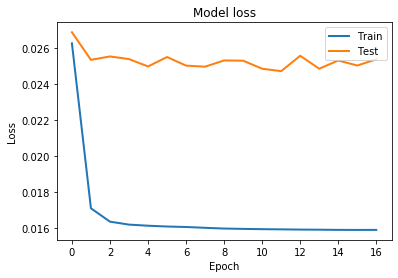

In [51]:
import matplotlib.pyplot as plt

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()